Here we want to explore the 10X data to see if we can 'find the ambient barcodes'

In [1]:
import pyximport
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance
import umi_tools.umi_methods as umi_methods
import umi_tools.Utilities as U
import collections
import pandas as pd
import numpy as np
import pysam
import regex
import glob
import CGAT.Fastq as Fastq
import CGAT.IOTools as IOTools
import matplotlib.pyplot as plt
from datetime import datetime
import random
%load_ext rpy2.ipython
%matplotlib inline  

In [2]:
bam_infile = "../run/raw/hgmm_6k_possorted_genome_bam.bam"
random.seed(123456789)

In [3]:
def phredToInt(phreds):
    return(list(map(lambda x: ord(x)-33, phreds)))

qualities = collections.defaultdict(
    lambda: collections.defaultdict(collections.Counter))


read2genome = {}
genome2reads = collections.Counter()
cell_umi_counts = collections.defaultdict(set)
cell_counts = collections.Counter()
cell2species = collections.defaultdict(collections.Counter)
inbam = pysam.Samfile(bam_infile)
cell_counts_mapped = collections.defaultdict(collections.Counter)
mitochondrial_reads = collections.Counter()

n = 0
subset = 0.1
skipped = 0

contigs = collections.Counter()

for read in inbam.fetch(until_eof=True):
        
    if random.uniform(0, 1) > subset:
        skipped += 1
        continue
        
    if read.is_secondary:
        continue
    
    cell = read.get_tag('CR')
    umi = read.get_tag('UR')
    
    if read.is_unmapped:
        cell_counts_mapped[cell]['unmapped'] += 1
    else:
        cell_counts_mapped[cell]['mapped'] += 1
        
        species, contig = read.reference_name.split("_")
        
        contigs[contig]+=1
        
        if contig == "MT":
            mitochondrial_reads[cell] += 1

        genome2reads[species] += 1
    
        if read.query_name in read2genome:
            raise ValueError("read: %s already seen: %s\n%s" %(
                read.query_name, read2genome[read.query_name], read))
        else:
            read2genome[read.query_name] = species
        
    n+=1
    
    if n % 1000000 == 0:
        print("processed %iM reads, skipped %iM reads: %s" % (
            (float(n)/1000000, float(skipped)/1000000, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))))
      
    cell_umi_counts[cell].add(umi)
    cell_counts[cell] += 1
    cell2species[cell][species] += 1
    
    qualities[cell]['read'].update(read.query_qualities)
    qualities[cell]['cell'].update(phredToInt(read.get_tag('CY')))
    qualities[cell]['umi'].update(phredToInt(read.get_tag('UY')))

print(genome2reads)
print(qualities['CTCGTACGTGCCTGCA'])

processed 1M reads, skipped 10M reads: 2017-08-16 18:05:48
processed 2M reads, skipped 21M reads: 2017-08-16 18:06:53
processed 3M reads, skipped 31M reads: 2017-08-16 18:07:57
processed 4M reads, skipped 41M reads: 2017-08-16 18:08:58
processed 5M reads, skipped 51M reads: 2017-08-16 18:10:03
processed 6M reads, skipped 62M reads: 2017-08-16 18:11:09
processed 7M reads, skipped 73M reads: 2017-08-16 18:12:13
processed 8M reads, skipped 83M reads: 2017-08-16 18:13:18
processed 9M reads, skipped 94M reads: 2017-08-16 18:14:26
processed 10M reads, skipped 104M reads: 2017-08-16 18:15:27
processed 11M reads, skipped 113M reads: 2017-08-16 18:16:32
processed 12M reads, skipped 123M reads: 2017-08-16 18:17:36
processed 13M reads, skipped 134M reads: 2017-08-16 18:18:41
processed 14M reads, skipped 144M reads: 2017-08-16 18:19:43
processed 15M reads, skipped 154M reads: 2017-08-16 18:20:41
processed 16M reads, skipped 164M reads: 2017-08-16 18:21:45
processed 17M reads, skipped 177M reads: 2

In [4]:
print(contigs.most_common())

[('1', 2737683), ('11', 2475922), ('19', 2466216), ('17', 2423078), ('7', 2180951), ('3', 1980340), ('5', 1851977), ('6', 1847139), ('2', 1822464), ('12', 1642303), ('9', 1575654), ('X', 1570832), ('15', 1505594), ('16', 1491413), ('4', 1445671), ('8', 1412199), ('10', 1339756), ('MT', 1268781), ('14', 847558), ('13', 684765), ('22', 618357), ('18', 464021), ('20', 404780), ('21', 212006), ('GL000220.1', 12852), ('Y', 9792), ('GL000195.1', 3241), ('GL000205.1', 2078), ('GL000191.1', 1811), ('JH584304.1', 1460), ('GL000194.1', 947), ('GL456379.1', 853), ('GL456382.1', 660), ('GL000222.1', 613), ('GL000218.1', 587), ('GL456233.1', 514), ('JH584300.1', 383), ('GL000223.1', 308), ('GL456216.1', 254), ('GL000219.1', 225), ('GL000221.1', 205), ('GL000192.1', 140), ('GL000211.1', 137), ('GL456367.1', 126), ('GL000212.1', 103), ('GL000244.1', 65), ('GL000214.1', 63), ('GL000242.1', 58), ('GL000249.1', 47), ('GL000243.1', 42), ('GL000217.1', 38), ('GL456390.1', 35), ('JH584294.1', 35), ('GL0002

In [5]:
def getCounterMeanPhred(counter):
    sum_prob = 0
    total_count = 0
    for number, count in counter.most_common():
        prob = 10**(number/(-10))
        sum_prob += (prob*count)
        total_count += count
    mean = sum_prob/total_count
    
    return mean 

print(cell)
print(qualities[cell]['read'])
print(getCounterMeanPhred(qualities[cell]['read']))
print(getCounterMeanPhred(collections.Counter((1,1,1,10))))
print(getCounterMeanPhred(collections.Counter((40,40,1,1))))

TTTGTCATCTTGGGTA
Counter({41: 83, 37: 43, 32: 26, 27: 17, 22: 16, 12: 11})
0.004390322227849884
0.6207461760432111
0.39721411736214074


In [6]:
def getCounterMean(counter):
    sum_of_numbers = sum([number*count for number, count in counter.most_common()])
    count = sum(count for n, count in counter.most_common())
    mean = sum_of_numbers / count
    return mean 

final_qualities = collections.defaultdict(lambda: collections.defaultdict(float))

for cell in qualities:
    try:
        final_qualities[cell]['read'] = getCounterMeanPhred(qualities[cell]['read'])
        final_qualities[cell]['cell'] = getCounterMeanPhred(qualities[cell]['cell'])
        final_qualities[cell]['umi'] = getCounterMeanPhred(qualities[cell]['umi'])
    except:
        print(cell)
        print(qualities[cell])

CTCGTACGTGCCTGCA
defaultdict(<class 'collections.Counter'>, {'read': Counter()})


In [7]:
rows = []
n = 0
for cell in cell_umi_counts:
    
    row = (cell, cell_counts[cell], len(cell_umi_counts[cell]),
           1-(len(cell_umi_counts[cell])/cell_counts[cell]))
    
    rows.append(row)

#print(cell_umi_counts)

In [8]:
duplication_df = pd.DataFrame.from_records(
    rows, columns=["cell", "count", "unique_umi_count", "dup._rate"])
print(duplication_df.head())
print(duplication_df.shape)
duplication_df = duplication_df[duplication_df['count']>10]
print(duplication_df.shape)
print(duplication_df.sort_values("count", ascending=False).head())

               cell  count  unique_umi_count  dup._rate
0  AGCATACCAGTTAACC      1                 1        0.0
1  TTCTCAACAAACCTAC      5                 5        0.0
2  CTGGTCTTCTACTATC      7                 7        0.0
3  CGACTTCGTACGTGTC      1                 1        0.0
4  TACTTGTAGGACAGCT      3                 3        0.0
(979191, 4)
(112790, 4)
                    cell  count  unique_umi_count  dup._rate
119715  GCCTCTATCAACACAC  18702             17914   0.042135
117361  TGGACGCGTCTTTCAT  17961             17216   0.041479
56533   TACAGTGAGACACTAA  16593             15879   0.043030
239128  TTGGAACCAGACAAAT  16182             15465   0.044308
701317  TTCGAAGCATCGGTTA  15818             15146   0.042483


In [9]:
def getSpecificity(cell, cell2species, cell_counts):
    hg_counts = cell2species[cell]["hg19"]
    mm_counts = cell2species[cell]["mm10"]
    total = hg_counts + mm_counts
    assert total == cell_counts[cell]
    specificity = max(hg_counts, mm_counts) / (hg_counts + mm_counts)
    return specificity

def getAlignmentRate(cell, cell_counts_mapped, cell_counts):
    mapped = cell_counts_mapped[cell]["mapped"]
    unmapped = cell_counts_mapped[cell]["unmapped"]
    total = mapped + unmapped
    #if not total == cell_counts[cell]:
    #    print(cell, total, cell_counts[cell])
    #    raise ValueError()
    alignment = float(mapped)/total
    return alignment
                                   
print(cell2species['GACTGCGAGGGCATGT'])
print(getSpecificity('GACTGCGAGGGCATGT', cell2species, cell_counts))
print(getAlignmentRate('GACTGCGAGGGCATGT', cell_counts_mapped, cell_counts))

Counter({'hg19': 25, 'mm10': 24})
0.5102040816326531
0.7755102040816326


In [10]:
duplication_df['read_qual'] = [final_qualities[cell]['read'] for cell in duplication_df['cell']]
duplication_df['umi_qual'] = [final_qualities[cell]['umi'] for cell in duplication_df['cell']]
duplication_df['cell_qual'] = [final_qualities[cell]['cell'] for cell in duplication_df['cell']]
duplication_df['specificity'] = list(
    map(lambda x: getSpecificity(x, cell2species, cell_counts), duplication_df['cell']))
duplication_df['alignment_rate'] = [getAlignmentRate(x, cell_counts_mapped, cell_counts)
                                    for x in duplication_df['cell']]

In [11]:
def checkError(barcode, whitelist):
    near_matches = set()
    comp_regex = regex.compile("(%s){e<=1}" % barcode)
    comp_regex2 = regex.compile("(%s){e<=1}" % barcode[:-1])
    b_length = len(barcode)
    for whitelisted_barcode in whitelist:
        w_length = len(whitelisted_barcode)
        if barcode == whitelisted_barcode:
            continue
        if (max(b_length, w_length) > (min(b_length, w_length) + 1)):
            continue
        if comp_regex.match(whitelisted_barcode) or comp_regex2.match(whitelisted_barcode):
            near_matches.add(whitelisted_barcode)
            if len(near_matches) > 1:
                return near_matches

    return near_matches


In [14]:
def getWhitelistHard(duplication_df, n=100, return_set=True):
    whitelist = duplication_df.sort_values("count", ascending=False)[0:n]["cell"]
    if return_set:
        return set(whitelist)
    else:
        return whitelist.tolist()

whitelist = getWhitelistHard(duplication_df, n=6000)
duplication_df['whitelist'] = [True if x in whitelist else False for x in duplication_df['cell']]
print(len(whitelist))

6000


In [46]:
def getRandomBarcode(b_length=16):
    bases = ["A", "T", "C", "G"]
    barcode = "".join(np.random.choice(bases, b_length, replace=True))
    return barcode

print(getRandomBarcode())

TCACGTGGCTCGATCA


In [116]:
from itertools import chain


def getErrorFreq(barcodes, whitelist):
    
    error = {}
    error["Error off whitelist"] = 0
    error["Error off (multiple) whitelist"] = 0 
    error["Error off (multiple) whitelist"] = 0
    error["No error"] = 0
    
    for barcode in barcodes:
        barcode_errors = checkError(barcode, whitelist)
    
        if len(barcode_errors) > 0:
            if len(barcode_errors) == 1:
                error["Error off whitelist"] += 1
            elif len(barcode_errors) == 2:
                error["Error off (multiple) whitelist"] += 1
            else:
                error["Error off (multiple) whitelist"] += 1
        else:
            error["No error"] += 1

    return error

sorted_duplication_df = duplication_df.sort_values(by="unique_umi_count", ascending=False)

rows = []
columns = ["threshold", "above_threshold",
           "Error_class", "count", "fraction"]

for whitelist_threshold in chain(range(2000,6000,1000), range(6000,8000,100)):
    print(whitelist_threshold)
    whitelist_barcodes = sorted_duplication_df['cell'][0:whitelist_threshold].tolist()
    
    n_nearly_barcodes = min(1000, max(10, int(whitelist_threshold * 0.2)))
    nearly_barcodes = sorted_duplication_df['cell'][
        whitelist_threshold:whitelist_threshold + n_nearly_barcodes]
    
    lower_error = getErrorFreq(nearly_barcodes, whitelist_barcodes)
    
    for k,v in lower_error.items():
        rows.append([whitelist_threshold, "Below", k, v, v/n_nearly_barcodes])
        
    upper_error = getErrorFreq(whitelist_barcodes[0:n_nearly_barcodes], whitelist_barcodes)
    
    for k,v in upper_error.items():
        rows.append([whitelist_threshold, "Above", k, v, v/n_nearly_barcodes])
    
    #for iteration in range(0, 10):
    #    random_barcodes = set([getRandomBarcode() for x in range(0,100)])
    #    random_error = getErrorFreq(random_barcodes, whitelist_barcodes)
    #
    #    for k,v in random_error.items():
    #        rows.append([whitelist_threshold, "random", k, v, v/n_nearly_barcodes])
    
errors_df = pd.DataFrame.from_records(rows, columns=columns)
print(errors_df.head())


2000
3000
4000
5000
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
   threshold above_threshold                     Error_class  count  fraction
0       2000           Below             Error off whitelist      3    0.0075
1       2000           Below                        No error    397    0.9925
2       2000           Below  Error off (multiple) whitelist      0    0.0000
3       2000           Above             Error off whitelist      5    0.0125
4       2000           Above                        No error    395    0.9875


In [114]:
no_errors_df = errors_df[errors_df['Error_class']=="No error"]
print(no_errors_df[no_errors_df['fraction']<0.95].head(20))

     threshold above_threshold Error_class  count  fraction
79        6900           Below    No error     94      0.94
109       7400           Below    No error     93      0.93
115       7500           Below    No error     93      0.93
127       7700           Below    No error     94      0.94


  threshold above_threshold                    Error_class count fraction
0      2000           Below            Error off whitelist     1     0.01
1      2000           Below                       No error    99     0.99
2      2000           Below Error off (multiple) whitelist     0     0.00
3      2000           Above            Error off whitelist     1     0.01
4      2000           Above                       No error    99     0.99
5      2000           Above Error off (multiple) whitelist     0     0.00


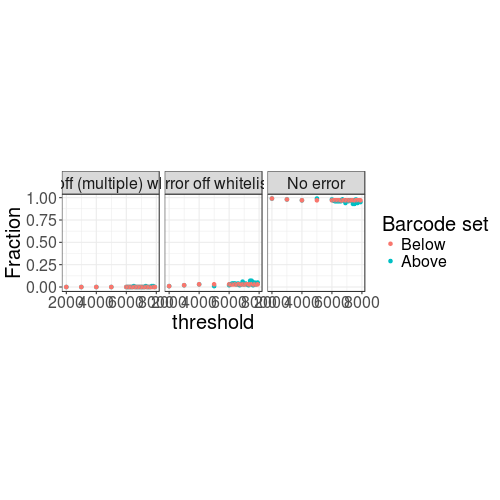

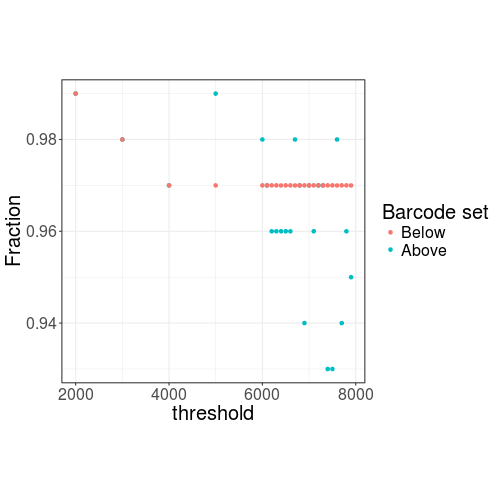

In [115]:
%%R -i errors_df -w 500 -h 500
library(ggplot2)
my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)
print(head(errors_df))

p <- ggplot(errors_df,
            aes(threshold, fraction, colour=as.factor(above_threshold))) +
geom_point() + my_theme + facet_wrap(~Error_class) + xlab("threshold") + ylab("Fraction") + 
scale_colour_discrete(name="Barcode set", labels=c("Below", "Above"))# + coord_cartesian(xlim=c(900,1100))

print(p)

p <- ggplot(errors_df[errors_df$Error_class=="No error",],
            aes(threshold, fraction, colour=as.factor(above_threshold))) +
geom_point() + my_theme + xlab("threshold") + ylab("Fraction") + 
scale_colour_discrete(name="Barcode set", labels=c("Below", "Above"))# + coord_cartesian(xlim=c(900,1100))

print(p)



  threshold above_threshold mean se
1      2000           Above 0.99 NA
2      2000           Below 0.99 NA
3      2000          random 1.00  0
4      3000           Above 0.98 NA
5      3000           Below 0.98 NA
6      3000          random 1.00  0


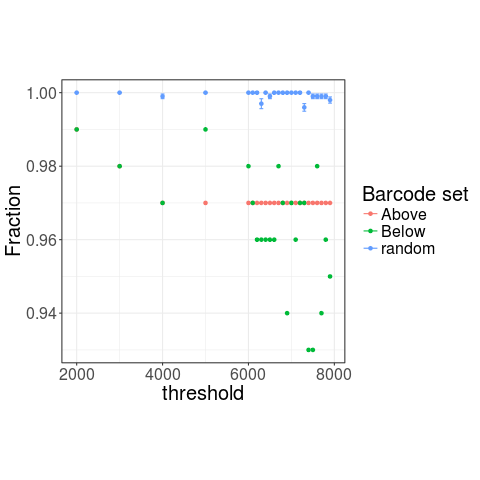

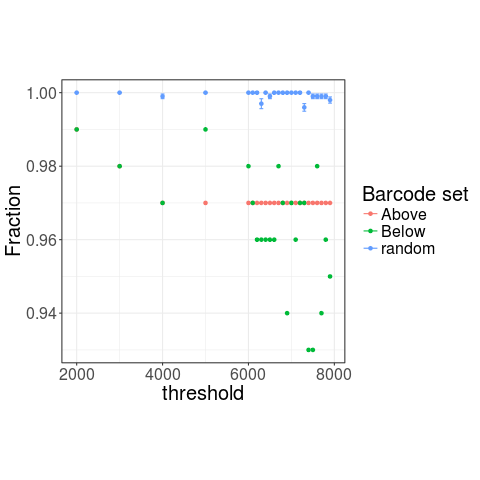

In [112]:
%%R -i errors_df2
library(plyr)

tmp_df <- ddply(errors_df2[errors_df2$Error_class=="No error",], c("threshold", "above_threshold"),
      function(x) c("mean"=mean(x$fraction), "se"=sd(x$fraction)/length(x)))

print(head(tmp_df))
          
p <- ggplot(tmp_df, aes(threshold, colour=as.factor(above_threshold))) +
          geom_point(aes(y=mean)) + 
          geom_errorbar(data=subset(tmp_df,above_threshold=="random"),
                        aes(ymax=mean+se, ymin=mean-se, y=mean)) +
          my_theme + xlab("threshold") + ylab("Fraction") + 
          scale_colour_discrete(name="Barcode set")# + coord_cartesian(xlim=c(900,1100))

print(p)

          
p <- ggplot(tmp_df, aes(threshold, colour=as.factor(above_threshold))) +
          geom_point(aes(y=mean)) + 
          geom_errorbar(aes(ymax=mean+se, ymin=mean-se, y=mean)) +
          my_theme + xlab("threshold") + ylab("Fraction") + 
          scale_colour_discrete(name="Barcode set")# + coord_cartesian(xlim=c(900,1100))

print(p)          

In [ ]:
print()

In [19]:
error = []
error_barcode = []

n = 0
for barcode in duplication_df['cell']:
    n+=1
    if n % 10000 == 0:
        print("processed %i cell barcodes" % n)
    barcode_errors = checkError(barcode, whitelist)
    
    if len(barcode_errors) > 0:
        if len(barcode_errors) == 1:
            error_barcode.append(list(barcode_errors)[0])
            error.append("Error off whitelist")
        else:
            error_barcode.append("")
            error.append("Error off (multiple) whitelist")
    
    else:
        error.append("")
        error_barcode.append("")               
    
duplication_df['full_error'] = error
duplication_df['error_barcode'] = error_barcode

processed 10000 cell barcodes
processed 20000 cell barcodes
processed 30000 cell barcodes
processed 40000 cell barcodes
processed 50000 cell barcodes
processed 60000 cell barcodes
processed 70000 cell barcodes
processed 80000 cell barcodes
processed 90000 cell barcodes
processed 100000 cell barcodes
processed 110000 cell barcodes


In [20]:
print(sum(duplication_df[duplication_df['whitelist']==True]['count']))
print(sum(duplication_df[duplication_df['full_error']=='Error off whitelist']['count']))

31335855
1385461


In [21]:

from scipy import interpolate
from scipy.interpolate import UnivariateSpline

112984
<class 'matplotlib.figure.Figure'>


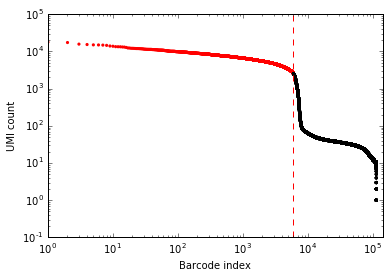

In [22]:
import matplotlib.lines as mlines

sorted_duplication_df = duplication_df.sort_values("unique_umi_count", ascending=False)
counts = sorted(duplication_df['unique_umi_count'], reverse=True)
colour_red = ["red" for x in range(0, 6000)]
colour_black = ["black" for x in range(0, len(counts)-6000)]
colours = colour_red + colour_black
print(len(colours))
fig = plt.figure()
fig3 = fig.add_subplot(111)
fig3.scatter(x=range(1, len(counts)+1), y=counts, c=colours,s=10, linewidths=0)
fig3.loglog()
fig3.set_xlim(0, len(counts)*1.25)
#sorted_duplication_df['x'] = range(1, len(sorted_duplication_df.index)+1)
#p = sorted_duplication_df.plot.scatter(
#    "x", "unique_umi_count", s=1, logx=True, logy=True, xlim=(0,max(sorted_duplication_df['x'])*1.25));
fig3.set_xlabel('Barcode index')
fig3.set_ylabel('UMI count')
fig3.axvline(6000, color='r', ls="dashed", label="selected")


print(type(fig3.figure))


In [32]:
duplication_df['N'] = ["N" in x for x in duplication_df['cell']]
duplication_df['Mt_reads'] = [mitochondrial_reads[cell] for cell in duplication_df['cell']]
duplication_df['Mt_fraction'] = duplication_df['Mt_reads']/duplication_df['count']
print(duplication_df.head())
#print(mitochondrial_reads['CCTTCCCCATCACGAT'])

                cell  count  unique_umi_count  dup._rate  read_qual  umi_qual  \
4   GACTGCGCAAGACGTG     29                27   0.068966   0.004934  0.000588   
44  TACACGAGTACCAGTT     59                58   0.016949   0.003746  0.000600   
46  CCTTCCCCATCACGAT   4757              4600   0.033004   0.005472  0.000559   
47  GGGTCTGTCAAACCGT     38                38   0.000000   0.004657  0.000506   
48  NTTGGTGGTCACCTAA     11                11   0.000000   0.019327  0.000343   

    cell_qual  specificity  alignment_rate whitelist           full_error  \
4    0.000389     0.724138        1.000000     False                        
44   0.000342     0.593220        0.983051     False  Error off whitelist   
46   0.000702     0.941980        0.953752      True                        
47   0.001062     0.657895        0.947368     False                        
48   0.041176     1.000000        0.909091     False  Error off whitelist   

       error_barcode      N  Mt_reads  Mt_fraction

In [33]:
%%R -i duplication_df

suppressMessages(library(ggplot2))
suppressMessages(library(Hmisc))

print(head(duplication_df))


               cell count unique_umi_count  dup._rate   read_qual     umi_qual
4  GACTGCGCAAGACGTG    29               27 0.06896552 0.004933816 0.0005879258
44 TACACGAGTACCAGTT    59               58 0.01694915 0.003745720 0.0005999586
46 CCTTCCCCATCACGAT  4757             4600 0.03300399 0.005471768 0.0005590342
47 GGGTCTGTCAAACCGT    38               38 0.00000000 0.004656738 0.0005060681
48 NTTGGTGGTCACCTAA    11               11 0.00000000 0.019327112 0.0003428498
64 GCGCAGTCAAACTGCT    23               23 0.00000000 0.007069091 0.0001301854
      cell_qual specificity alignment_rate whitelist          full_error
4  0.0003885483   0.7241379      1.0000000     FALSE                    
44 0.0003419230   0.5932203      0.9830508     FALSE Error off whitelist
46 0.0007019961   0.9419802      0.9537524      TRUE                    
47 0.0010617356   0.6578947      0.9473684     FALSE                    
48 0.0411763378   1.0000000      0.9090909     FALSE Error off whitelist
64 0.0004

In [34]:
%%R
my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)


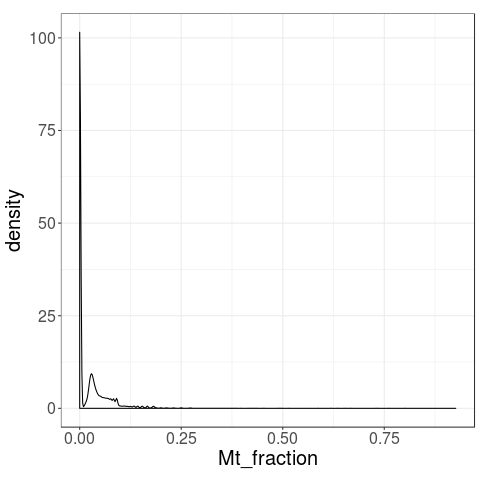

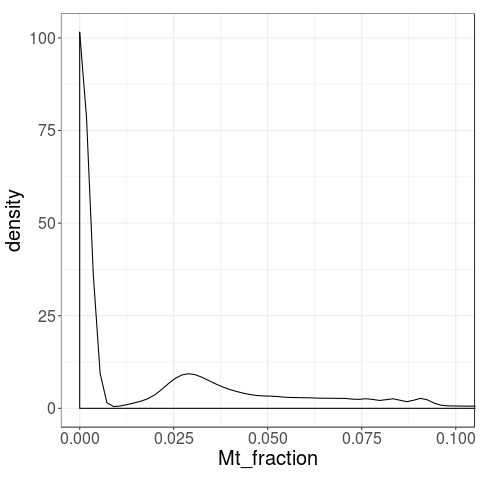

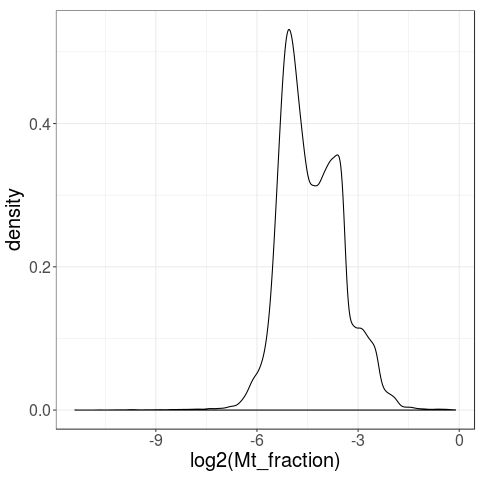

In [40]:
%%R
print(ggplot(duplication_df, aes(Mt_fraction)) + my_theme + geom_density())
print(ggplot(duplication_df, aes(Mt_fraction)) + my_theme + geom_density() + coord_cartesian(xlim=c(0,0.1)))
print(ggplot(duplication_df, aes(log2(Mt_fraction))) + my_theme + geom_density())
       

In [ ]:
%%R -w 1000 -h 1000
duplication_df$specificity_binary <- duplication_df$specificity > 0.8

threshold = duplication_df[order(-duplication_df$count), "count"][6000]
threshold_umi = duplication_df[order(-duplication_df$unique_umi_count), "unique_umi_count"][6000]
print(log(threshold, 10))

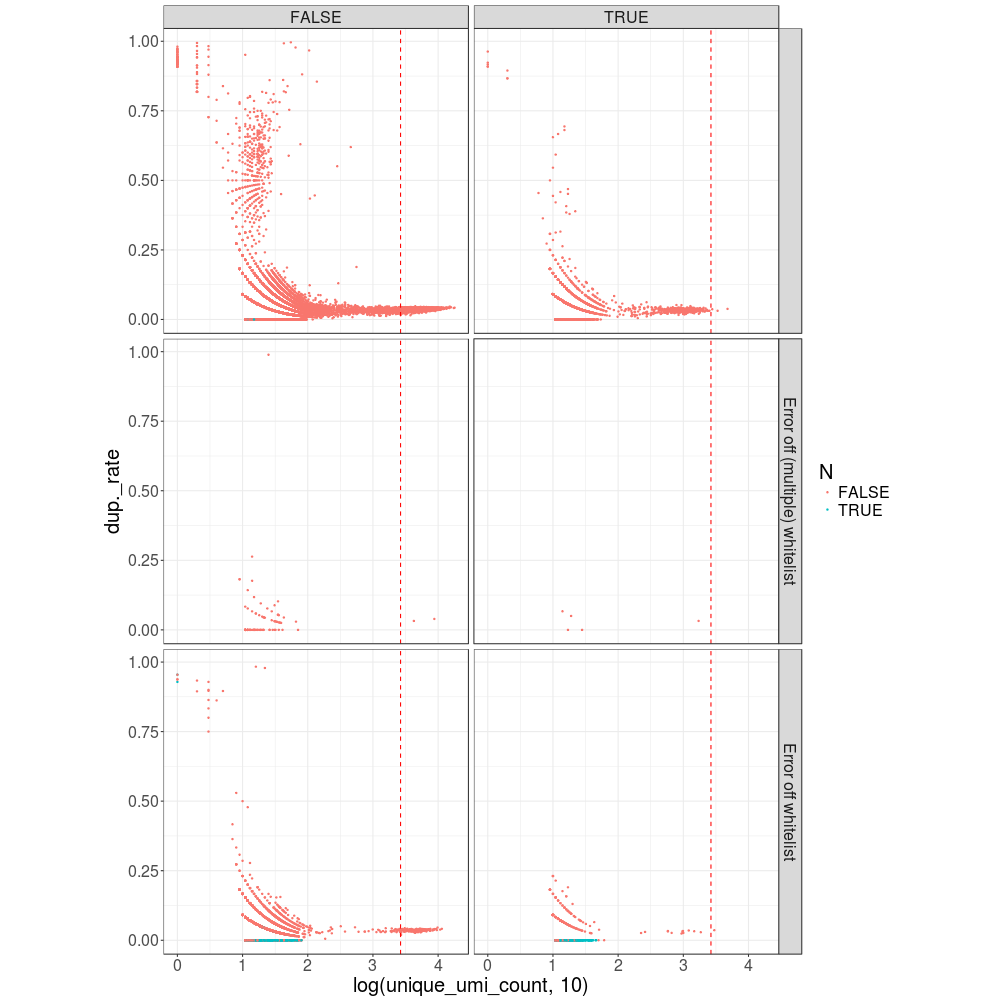

In [51]:
%%R -w 1000 -h 1000
duplication_df['Mt_fraction_binary'] <- duplication_df$Mt_fraction>0.1
p <- ggplot(duplication_df, aes(log(unique_umi_count,10), dup._rate, colour=N)) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
facet_grid(full_error~Mt_fraction_binary) 

print(p) 

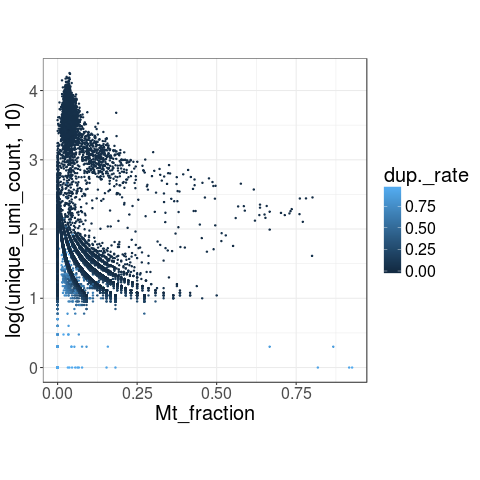

In [55]:
%%R

p <- ggplot(duplication_df, aes(Mt_fraction, log(unique_umi_count, 10), colour=dup._rate)) +
geom_point(size=0.5) + my_theme

print(p) 

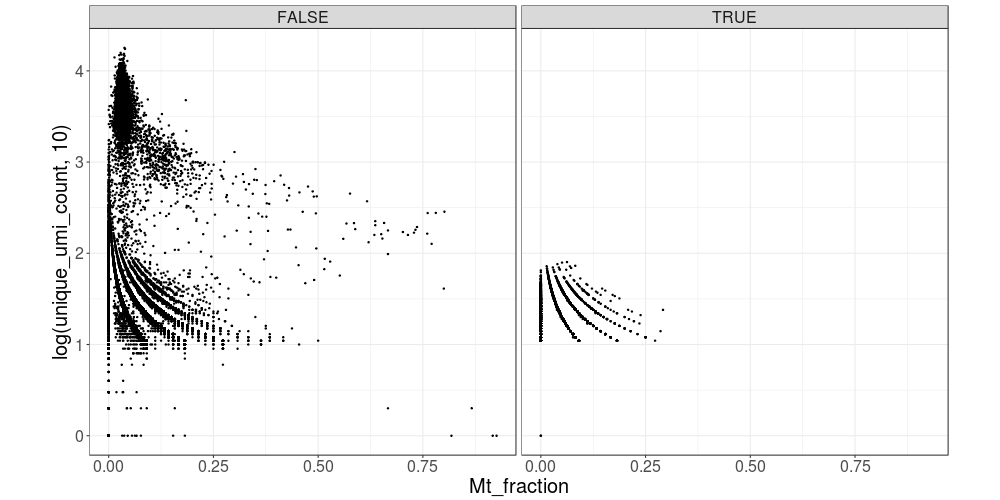

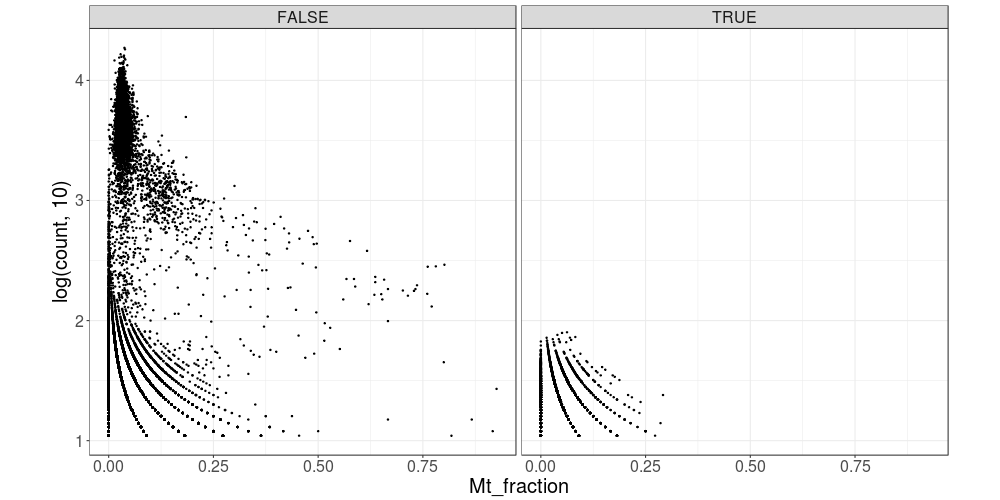

In [64]:
%%R  -w 1000 -h 500

p <- ggplot(duplication_df, aes(Mt_fraction, log(unique_umi_count, 10))) +
geom_point(size=0.5) + my_theme + facet_wrap(~N)

print(p) 

p <- ggplot(duplication_df, aes(Mt_fraction, log(count, 10))) +
geom_point(size=0.5) + my_theme + facet_wrap(~N)

print(p)



                cell count unique_umi_count  dup._rate   read_qual     umi_qual
46  CCTTCCCCATCACGAT  4757             4600 0.03300399 0.005471768 0.0005590342
203 GCTTGAAGTGGTCCGT  3447             3339 0.03133159 0.005580291 0.0005299962
243 CTAAGACGTTATCGGT  9721             9372 0.03590166 0.005001447 0.0004878936
435 CAAGTTGGTTGACGTT  5425             5221 0.03760369 0.005311954 0.0004177629
521 TTAGGCAAGTTACCCA  3406             3285 0.03552554 0.004957600 0.0004892958
544 GCGCGATCACTACAGT  3304             3178 0.03813559 0.005328714 0.0005697365
       cell_qual specificity alignment_rate whitelist full_error error_barcode
46  0.0007019961   0.9419802      0.9537524      TRUE                         
203 0.0007616142   0.9802727      0.9286336      TRUE                         
243 0.0006237423   0.9514453      0.9630696      TRUE                         
435 0.0007371972   0.9826728      0.9469124      TRUE                         
521 0.0006000043   0.9788608      0.9315913  

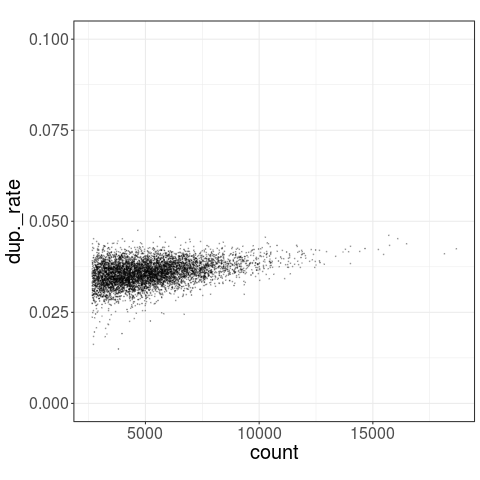

In [115]:
%%R
print(head(duplication_df[duplication_df$whitelist==TRUE,]))
p <- ggplot(duplication_df[duplication_df$whitelist==TRUE,], aes(count, dup._rate)) +
geom_point(size=0.25, alpha=0.25) + my_theme
p <- p + coord_cartesian(ylim=c(0,0.1))
print(p)

tmp_df <- duplication_df[duplication_df$whitelist==TRUE,]
tmp_df <- tmp_df[tmp_df$dup._rate<0.1,]

print(summary(lm(dup._rate ~ count, data=tmp_df)))
#count_coef = 6.148e-07
count_coef <- lm(dup._rate ~ count, data=tmp_df)$coefficients[['count']]
print(count_coef)



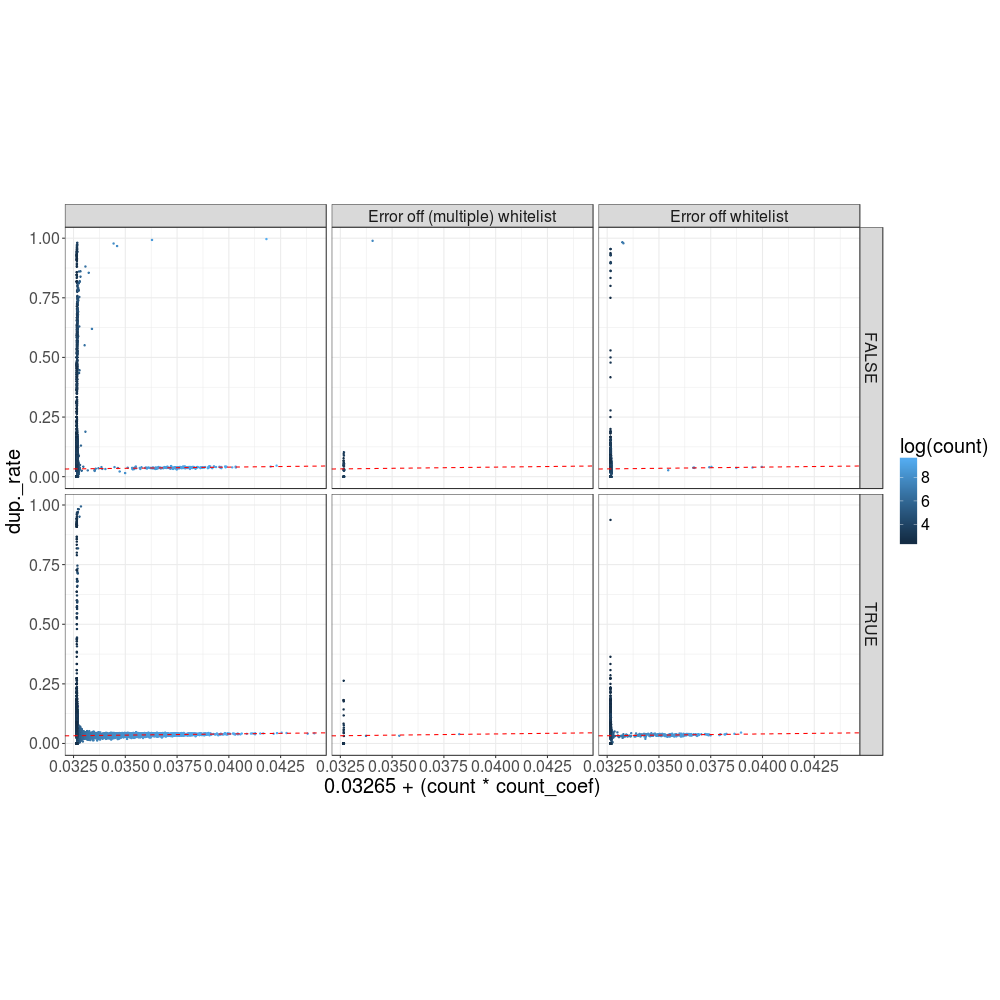

In [118]:
%%R  -w 1000 -h 1000
p <- ggplot(duplication_df, aes(3.265e-02 + (count*count_coef), dup._rate, colour=log(count))) +
geom_point(size=0.5) + my_theme + facet_grid(specificity_binary~full_error) +
geom_abline(slope=1, colour="red", linetype=2)

print(p)

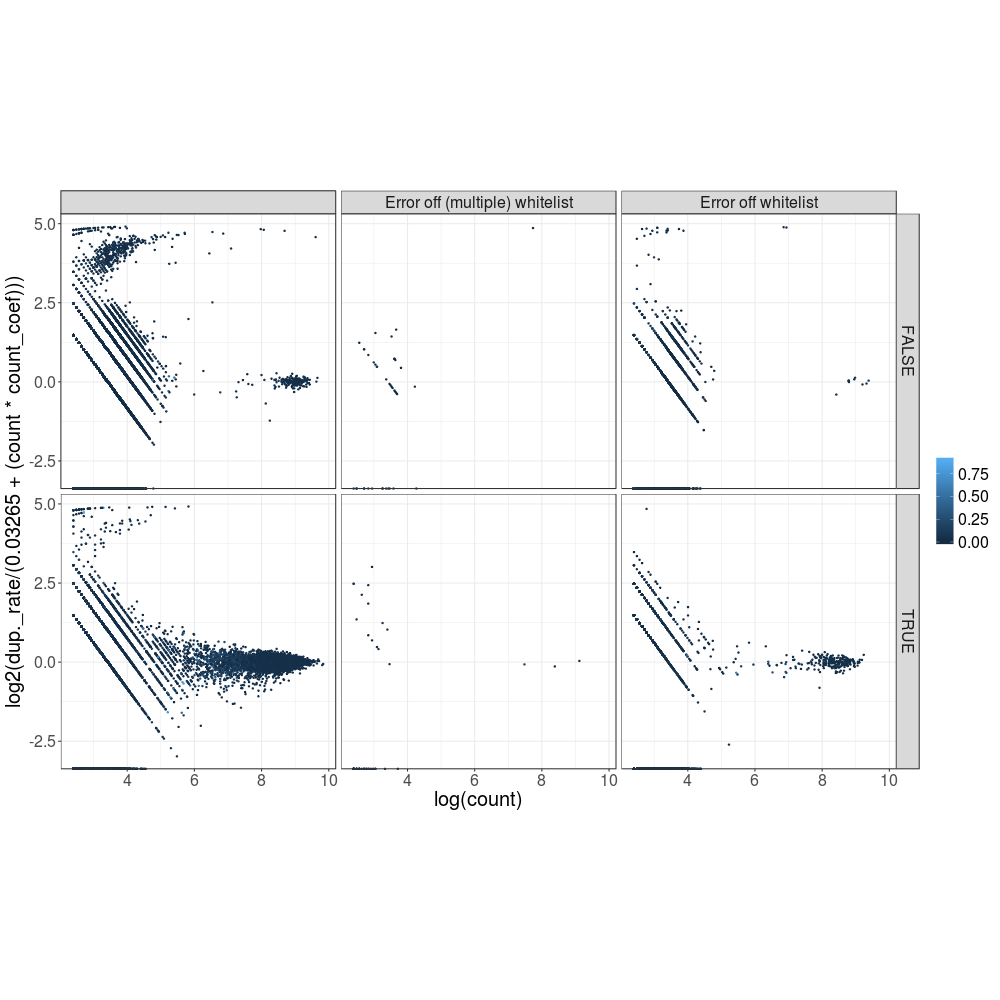

In [119]:
%%R  -w 1000 -h 1000

p <- ggplot(duplication_df, aes(log(count),log2(dup._rate/(3.265e-02 + (count*count_coef))),
                                colour=Mt_fraction)) +
geom_point(size=0.5) + my_theme + facet_grid(specificity_binary~full_error) +
scale_colour_continuous(name="")

print(p)



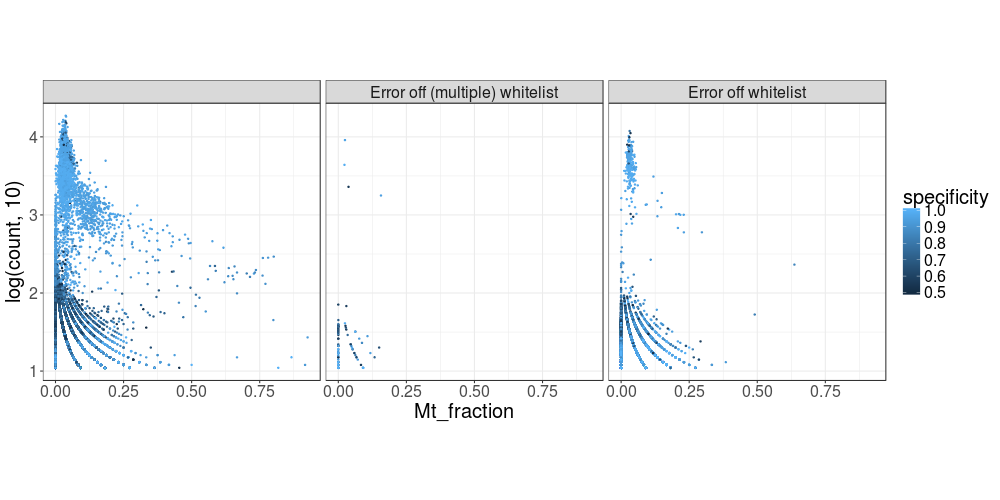

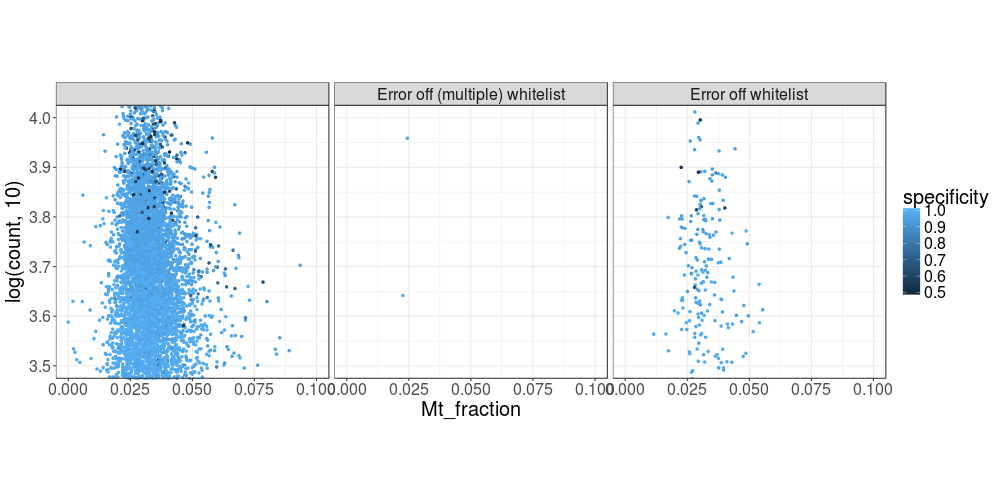

In [120]:
%%R  -w 1000 -h 500

p <- ggplot(duplication_df, aes(Mt_fraction, log(count, 10), colour=specificity)) +
geom_point(size=0.5) + my_theme + facet_wrap(~full_error)

print(p)

p <- ggplot(duplication_df, aes(Mt_fraction, log(count, 10), colour=specificity)) +
geom_point(size=1) + my_theme + facet_wrap(~full_error) + coord_cartesian(xlim=c(0,0.1), ylim=c(3.5,4))

print(p)

[1] 3.423901


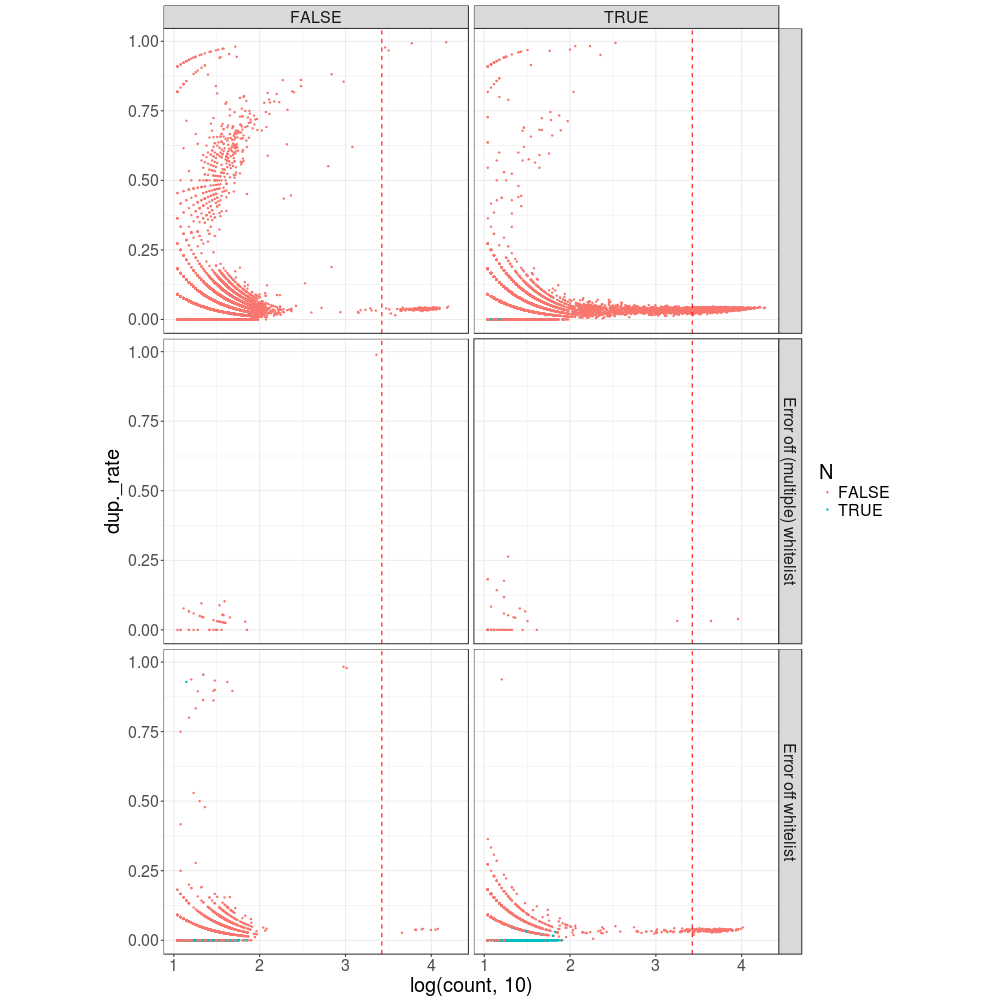

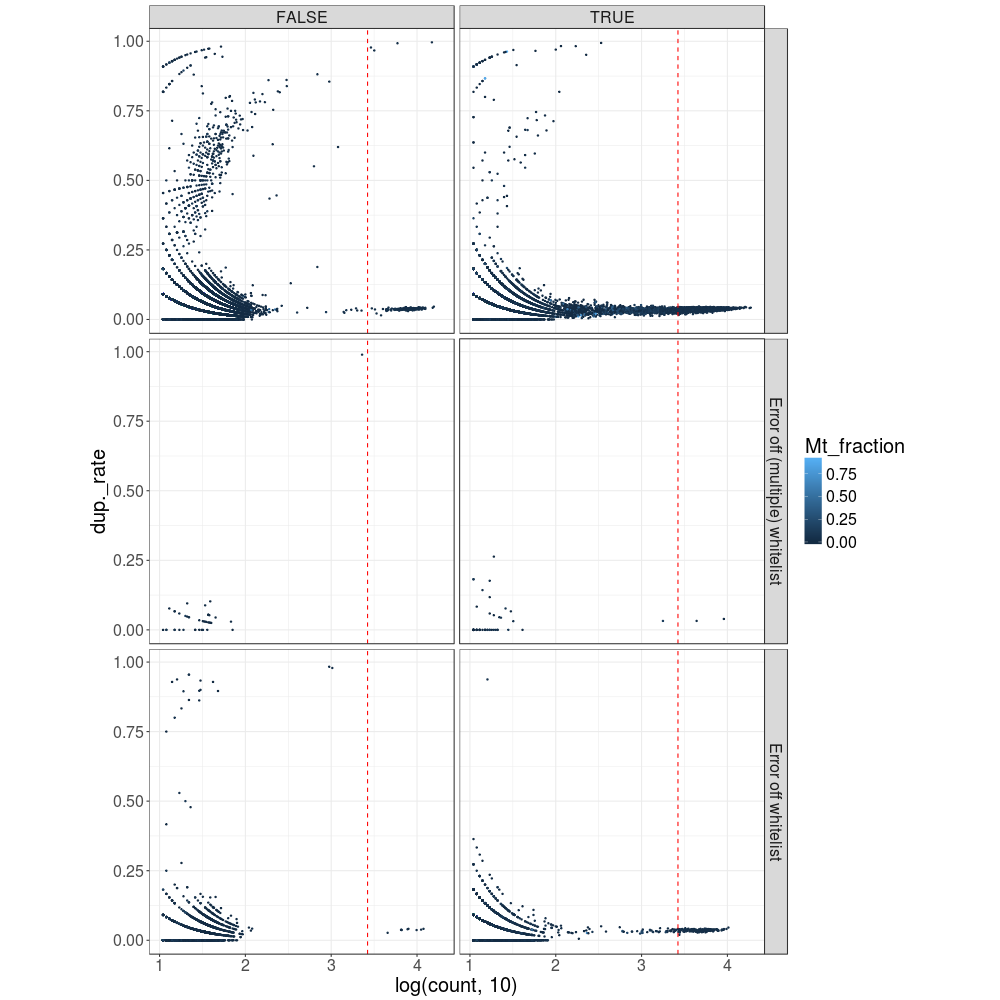

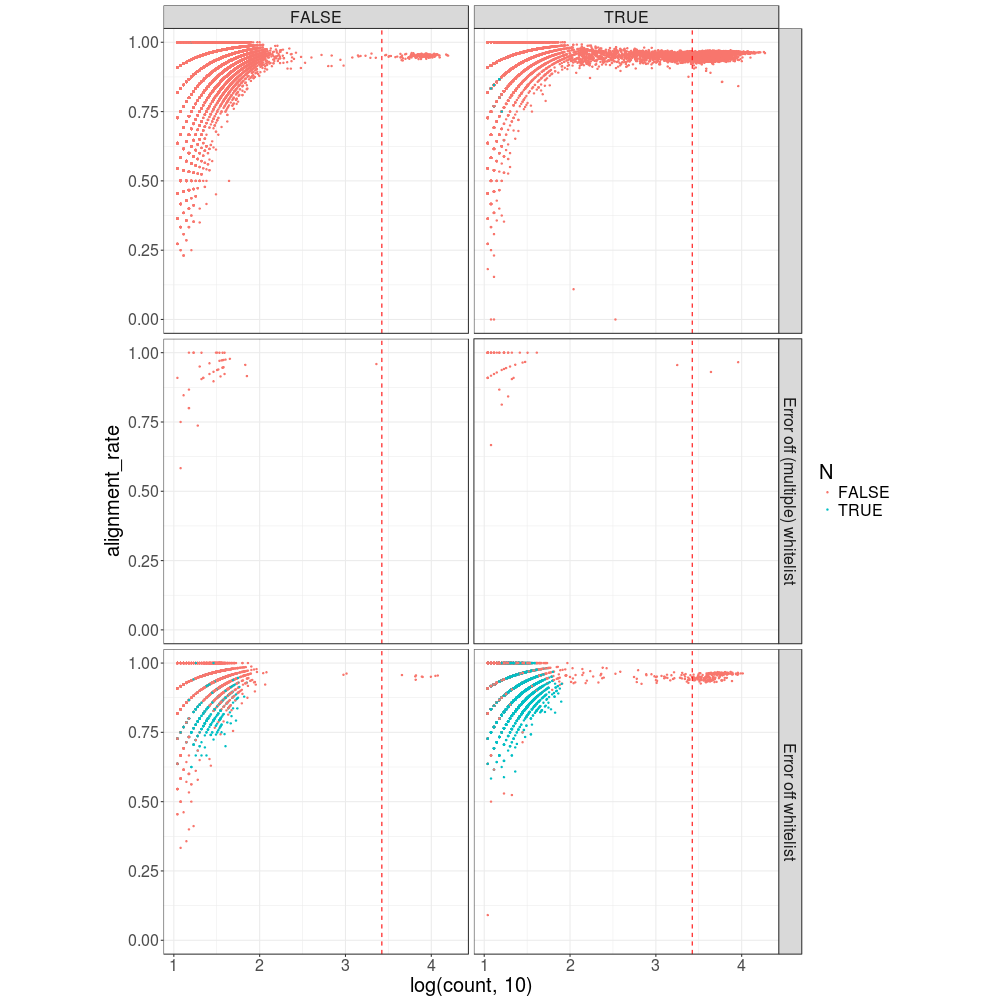

In [35]:
%%R -w 1000 -h 1000

p <- ggplot(duplication_df, aes(log(count,10), dup._rate, colour=log(cell_qual,10))) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2)

#print(p) 

p <- ggplot(duplication_df, aes(log(count,10), dup._rate, colour=N)) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
facet_grid(full_error~specificity_binary) #+
#scale_colour_continuous(low="red", high="steelblue", limits=c(20,35), na.value="steelblue")

print(p) 

p <- ggplot(duplication_df, aes(log(count,10), dup._rate, colour=Mt_fraction)) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
facet_grid(full_error~specificity_binary) #+
#scale_colour_continuous(low="red", high="steelblue", limits=c(20,35), na.value="steelblue")

print(p) 


p <- ggplot(duplication_df, aes(log(count,10), alignment_rate, colour=N)) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
facet_grid(full_error~specificity_binary) #+
#scale_colour_continuous(low="red", high="steelblue", limits=c(20,35), na.value="steelblue")

print(p) 

p <- ggplot(duplication_df, aes(log(read_qual,10), dup._rate, colour=N)) +
geom_point(size=0.5) + my_theme  +
facet_grid(full_error~specificity_binary)

#print(p) 

p <- ggplot(duplication_df, aes(log(count,10))) + geom_density(adjust = 5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(2,5), ylim=c(0,0.05))

#print(p) 



In [28]:
%%R
print(dim(duplication_df))
duplication_error_barcodes = duplication_df[duplication_df['full_error']=="Error off whitelist",]
duplication_white_barcodes = duplication_df[duplication_df['whitelist']==TRUE,c("cell", "count")]
colnames(duplication_white_barcodes) <- c("cell", "true_count")
print(dim(duplication_error_barcodes))
print(dim(duplication_white_barcodes))

duplication_error_barcodes <- merge(
    duplication_error_barcodes, duplication_white_barcodes, by.x="error_barcode", by.y="cell", all.x=TRUE)

print(dim(duplication_error_barcodes))
print(head(duplication_error_barcodes))

print(sum(duplication_error_barcodes$count))
print(sum(duplication_white_barcodes$true_count))

[1] 113062     14
[1] 13025    14
[1] 6000    2
[1] 13025    15
     error_barcode             cell count unique_umi_count  dup._rate
1 AAACCTGAGAGACTTA NAACCTGAGAGACTTA    16               16 0.00000000
2 AAACCTGAGCTTTGGT NAACCTGAGCTTTGGT    31               31 0.00000000
3 AAACCTGAGCTTTGGT AACCTGAGCTTTGGTG    15               14 0.06666667
4 AAACCTGAGCTTTGGT AACCTGAGCTTTGGTA    22               22 0.00000000
5 AAACCTGAGGTAAACT AACCTGAGGTAAACTT    16               16 0.00000000
6 AAACCTGAGGTAAACT AACCTGAGGTAAACTA    19               18 0.05263158
    read_qual     umi_qual    cell_qual specificity alignment_rate whitelist
1 0.018602698 2.081043e-04 0.0399233111   1.0000000      1.0000000     FALSE
2 0.021756583 8.796956e-04 0.0401951407   0.9032258      0.9354839     FALSE
3 0.003084358 9.399619e-04 0.0004721125   1.0000000      1.0000000     FALSE
4 0.003676578 8.412327e-05 0.0003801580   1.0000000      1.0000000     FALSE
5 0.002572786 1.459403e-04 0.0004569302   0.5625000      1.00

In [29]:
%%R

duplication_error_barcodes$difference <- duplication_error_barcodes$count/duplication_error_barcodes$true_count

difference_per_true_barcode_df <- as.data.frame(as.list(aggregate(duplication_error_barcodes$count,
                    by=list("tb" = duplication_error_barcodes$error_barcode),
                    FUN = function(x) c(mean = mean(x), sd = sd(x), n = length(x)))))

difference_per_true_barcode_df <- merge(difference_per_true_barcode_df,
                                        duplication_white_barcodes,
                                        by.x="tb", by.y="cell",all.x=TRUE) 
                        
colnames(difference_per_true_barcode_df) <- c("TB", "mean", "sd", "n", "tb_count")
                        
print(head(difference_per_true_barcode_df))
                        
final_duplication_error_barcodes <- merge(duplication_error_barcodes, difference_per_true_barcode_df,
                                    by.x="error_barcode", by.y="TB", all.x=TRUE)
print(head(final_duplication_error_barcodes))

                TB      mean         sd n tb_count
1 AAACCTGAGAGACTTA  16.00000         NA 1     3559
2 AAACCTGAGCTTTGGT  22.66667   8.020806 3     7434
3 AAACCTGAGGTAAACT  23.80000  11.410521 5     9996
4 AAACCTGAGGTGTGGT  23.00000         NA 1     4946
5 AAACCTGAGTGTTAGA 222.66667 506.768455 6     6297
6 AAACCTGCACCACCAG  22.00000         NA 1     4839
     error_barcode             cell count unique_umi_count  dup._rate
1 AAACCTGAGAGACTTA NAACCTGAGAGACTTA    16               16 0.00000000
2 AAACCTGAGCTTTGGT NAACCTGAGCTTTGGT    31               31 0.00000000
3 AAACCTGAGCTTTGGT AACCTGAGCTTTGGTG    15               14 0.06666667
4 AAACCTGAGCTTTGGT AACCTGAGCTTTGGTA    22               22 0.00000000
5 AAACCTGAGGTAAACT AACCTGAGGTAAACTT    16               16 0.00000000
6 AAACCTGAGGTAAACT AACCTGAGGTAAACTA    19               18 0.05263158
    read_qual     umi_qual    cell_qual specificity alignment_rate whitelist
1 0.018602698 2.081043e-04 0.0399233111   1.0000000      1.0000000     FALSE

In [63]:
%%R
print(head(duplication_error_barcodes))

     error_barcode             cell count unique_umi_count  dup._rate
1 AAACCTGAGAGACTTA NAACCTGAGAGACTTA    16               16 0.00000000
2 AAACCTGAGCTTTGGT NAACCTGAGCTTTGGT    31               31 0.00000000
3 AAACCTGAGCTTTGGT AACCTGAGCTTTGGTG    15               14 0.06666667
4 AAACCTGAGCTTTGGT AACCTGAGCTTTGGTA    22               22 0.00000000
5 AAACCTGAGGTAAACT AACCTGAGGTAAACTT    16               16 0.00000000
6 AAACCTGAGGTAAACT AACCTGAGGTAAACTA    19               18 0.05263158
    read_qual     umi_qual    cell_qual specificity alignment_rate whitelist
1 0.018602698 2.081043e-04 0.0399233111   1.0000000      1.0000000     FALSE
2 0.021756583 8.796956e-04 0.0401951407   0.9032258      0.9354839     FALSE
3 0.003084358 9.399619e-04 0.0004721125   1.0000000      1.0000000     FALSE
4 0.003676578 8.412327e-05 0.0003801580   1.0000000      1.0000000     FALSE
5 0.002572786 1.459403e-04 0.0004569302   0.5625000      1.0000000     FALSE
6 0.006066924 8.439128e-04 0.0015086685   0.6315

In [65]:
%%R
print(difference_per_true_barcode_df$true_count)

NULL


     error_barcode             cell count unique_umi_count  dup._rate
1 AAACCTGAGAGACTTA NAACCTGAGAGACTTA    16               16 0.00000000
2 AAACCTGAGCTTTGGT NAACCTGAGCTTTGGT    31               31 0.00000000
3 AAACCTGAGCTTTGGT AACCTGAGCTTTGGTG    15               14 0.06666667
4 AAACCTGAGCTTTGGT AACCTGAGCTTTGGTA    22               22 0.00000000
5 AAACCTGAGGTAAACT AACCTGAGGTAAACTT    16               16 0.00000000
6 AAACCTGAGGTAAACT AACCTGAGGTAAACTA    19               18 0.05263158
    read_qual     umi_qual    cell_qual specificity alignment_rate whitelist
1 0.018602698 2.081043e-04 0.0399233111   1.0000000      1.0000000     FALSE
2 0.021756583 8.796956e-04 0.0401951407   0.9032258      0.9354839     FALSE
3 0.003084358 9.399619e-04 0.0004721125   1.0000000      1.0000000     FALSE
4 0.003676578 8.412327e-05 0.0003801580   1.0000000      1.0000000     FALSE
5 0.002572786 1.459403e-04 0.0004569302   0.5625000      1.0000000     FALSE
6 0.006066924 8.439128e-04 0.0015086685   0.6315

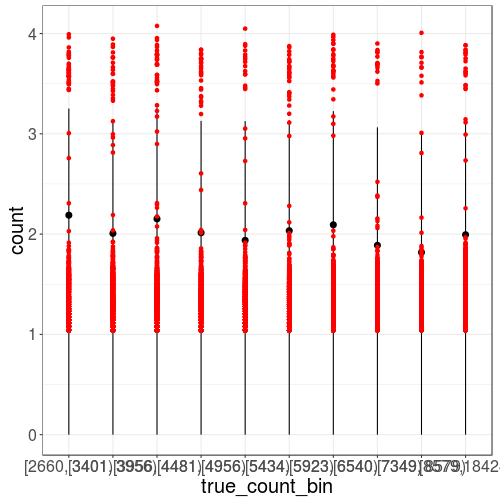

In [87]:
%%R -w 500 -h 500 
duplication_error_barcodes$true_count_bin = cut2(duplication_error_barcodes$true_count, g=10)
print(head(duplication_error_barcodes))

p <- ggplot(duplication_error_barcodes, aes(true_count_bin, count)) +
my_theme +
stat_summary(geom="pointrange",
             fun.y=function(x) log(mean(x),10),
             fun.ymin=function(x) 0,
             fun.ymax=function(x) log((mean(x)+(2*sd(x))),10)) +
geom_point(aes(y=log(count,10)), colour="red")
#geom_point(aes(y=log(mean,10)))
#geom_point(aes(y=log(sd,10)), colour="red") #+
#geom_errorbar(aes(ymin=log(mean,10)-log(sd,10), ymax=log(mean,10)+log(sd,10), width=0.01))
#geom_errorbar(aes(ymin=log(mean-(3*sd),10), ymax=log(mean-(3*sd),10)), width=0.2)

print(p)

     error_barcode             cell count unique_umi_count  dup._rate
1 AAACCTGAGAGACTTA NAACCTGAGAGACTTA    16               16 0.00000000
2 AAACCTGAGCTTTGGT NAACCTGAGCTTTGGT    31               31 0.00000000
3 AAACCTGAGCTTTGGT AACCTGAGCTTTGGTG    15               14 0.06666667
4 AAACCTGAGCTTTGGT AACCTGAGCTTTGGTA    22               22 0.00000000
5 AAACCTGAGGTAAACT AACCTGAGGTAAACTT    16               16 0.00000000
6 AAACCTGAGGTAAACT AACCTGAGGTAAACTA    19               18 0.05263158
    read_qual     umi_qual    cell_qual specificity alignment_rate whitelist
1 0.018602698 2.081043e-04 0.0399233111   1.0000000      1.0000000     FALSE
2 0.021756583 8.796956e-04 0.0401951407   0.9032258      0.9354839     FALSE
3 0.003084358 9.399619e-04 0.0004721125   1.0000000      1.0000000     FALSE
4 0.003676578 8.412327e-05 0.0003801580   1.0000000      1.0000000     FALSE
5 0.002572786 1.459403e-04 0.0004569302   0.5625000      1.0000000     FALSE
6 0.006066924 8.439128e-04 0.0015086685   0.6315

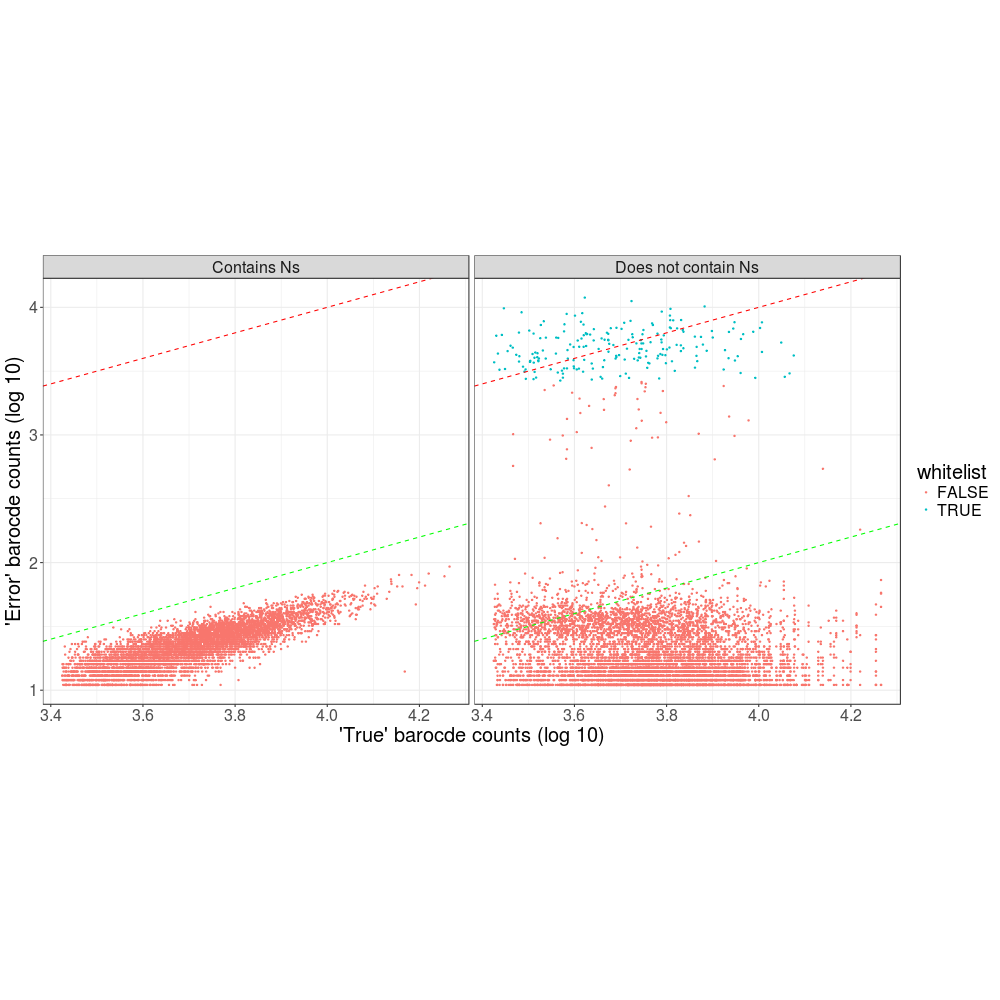

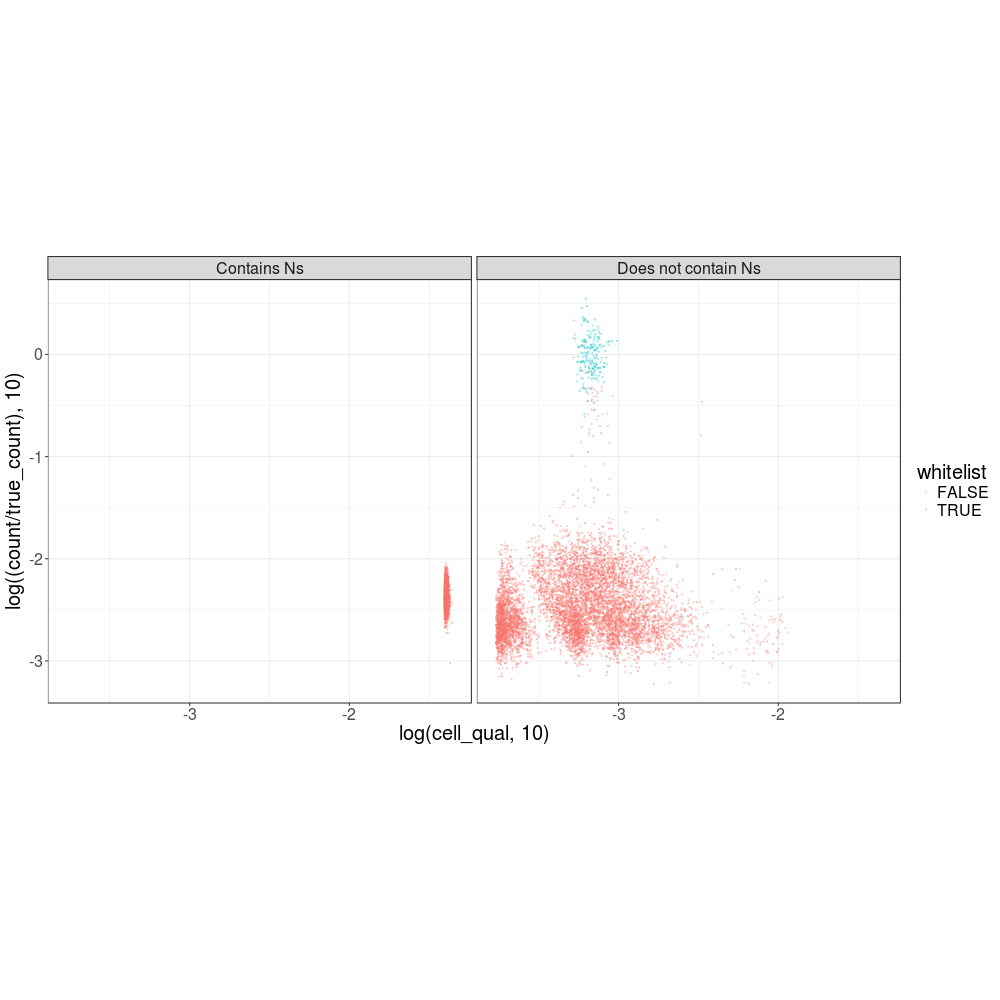

In [97]:
%%R -w 1000 -h 1000

print(head(final_duplication_error_barcodes ))

final_duplication_error_barcodes$N[final_duplication_error_barcodes$N==T] <- "Contains Ns"
final_duplication_error_barcodes$N[final_duplication_error_barcodes$N==F] <- "Does not contain Ns"

p <- ggplot(final_duplication_error_barcodes, aes(log(true_count,10), log(count,10), colour=whitelist)) +
geom_point(size=0.5) + my_theme + geom_abline(slope=1, colour="red", linetype=2) +
facet_wrap(~N) +
geom_abline(slope=1, colour="green", linetype=2, intercept=-2) +
xlab("'True' barocde counts (log 10)") +
ylab("'Error' barocde counts (log 10)") #scale_colour_continuous(name="Average Cell\nError rate\n(log 10) ")

print(p)


p <- ggplot(final_duplication_error_barcodes , aes(log(cell_qual,10), log((count/true_count),10), colour=whitelist)) +
facet_wrap(~N) + geom_point(size=0.5, alpha=0.25) + my_theme

print(p)

p <- ggplot(final_duplication_error_barcodes , aes(log(umi_qual,10), log((count/true_count),10), colour=whitelist)) +
facet_wrap(~N) + geom_point(size=0.5, alpha=0.25) + my_theme

#print(p)

p <- ggplot(final_duplication_error_barcodes , aes(log(read_qual,10), log((count/true_count),10), colour=whitelist)) +
facet_wrap(~N) + geom_point(size=0.5, alpha=0.25) + my_theme

#print(p)

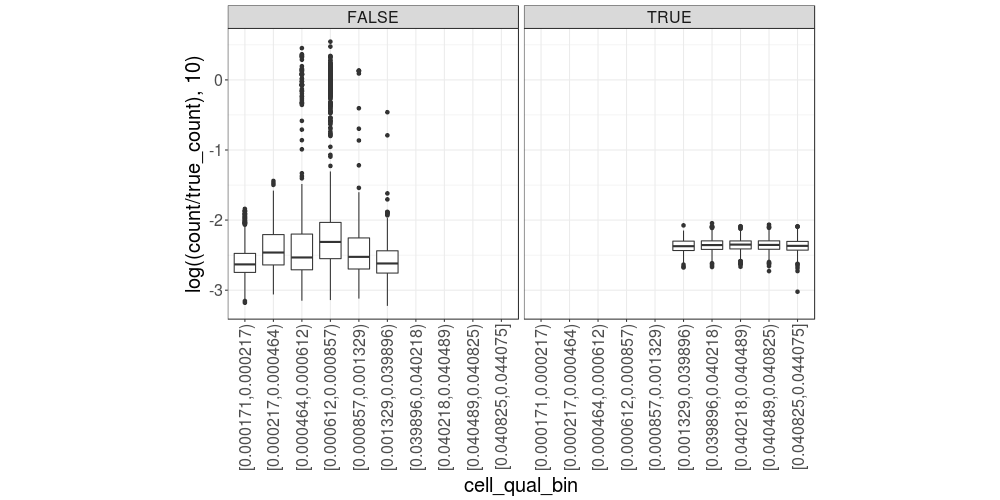

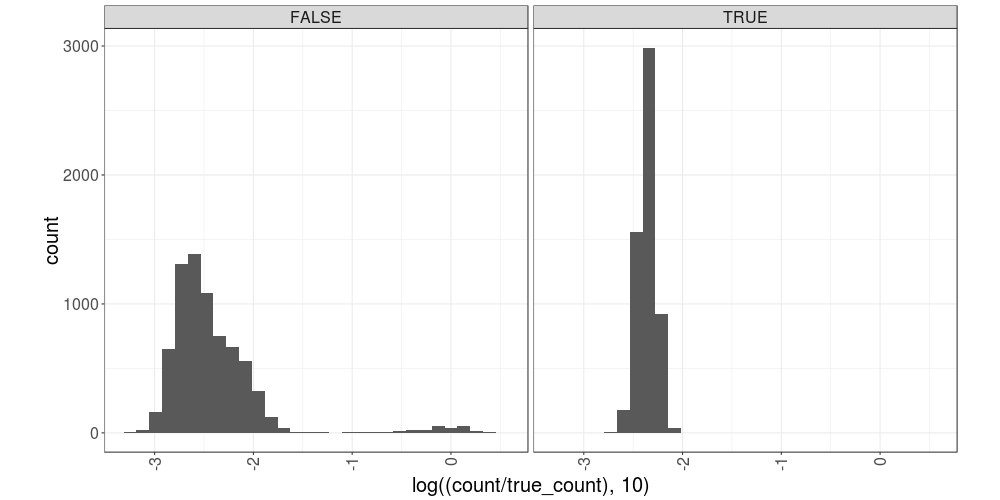

In [41]:
%%R -h 500 -w 1000
library(Hmisc)
duplication_error_barcodes$cell_qual_bin = cut2(duplication_error_barcodes$cell_qual, g=10)

p <- ggplot(duplication_error_barcodes, aes(cell_qual_bin, log((count/true_count),10))) +
geom_boxplot() + my_theme + facet_wrap(~N) +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)

p <- ggplot(duplication_error_barcodes, aes(log((count/true_count),10))) +
geom_histogram() + my_theme + facet_wrap(~N) +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)

In [33]:
%%R
tmp_df <- duplication_error_barcodes[duplication_error_barcodes$cell_qual<36,]
print(dim(tmp_df))
tmp_df <- tmp_df[tmp_df$cell_qual>35,]
print(dim(tmp_df))
tmp_df <- tmp_df[log((tmp_df$count/tmp_df$true_count),10)>(-3),]
print(head(tmp_df))
print(dim(tmp_df))

[1] 13025    17
[1]  0 17
 [1] error_barcode      cell               count              unique_umi_count  
 [5] dup._rate          read_qual          umi_qual           cell_qual         
 [9] specificity        alignment_rate     whitelist          full_error        
[13] N                  specificity_binary true_count         difference        
[17] cell_qual_bin     
<0 rows> (or 0-length row.names)
[1]  0 17


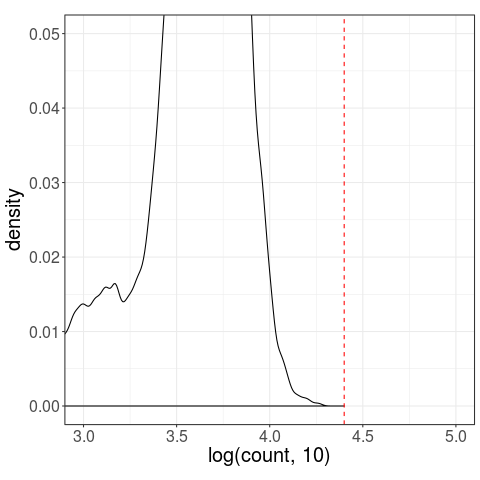

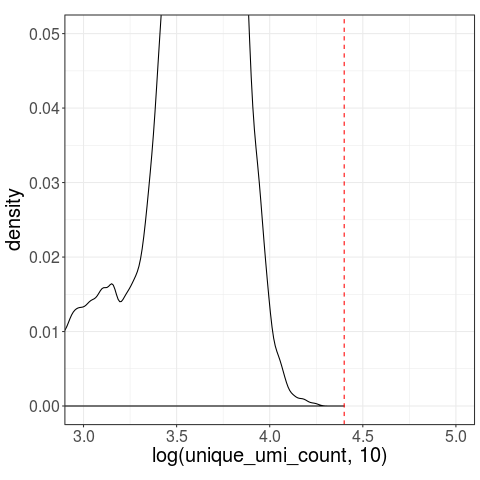

In [34]:
%%R
manual_threshold = 10^4.4
duplication_df$knee <- duplication_df$count > manual_threshold

p <- ggplot(duplication_df, aes(log(count,10))) + geom_density() + my_theme  +
geom_vline(xintercept=log(manual_threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(3,5), ylim=c(0,0.05))

print(p) 

p <- ggplot(duplication_df, aes(log(unique_umi_count,10))) + geom_density() + my_theme  +
geom_vline(xintercept=log(manual_threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(3,5), ylim=c(0,0.05))

print(p) 


                   cell count unique_umi_count  dup._rate   read_qual
28992  GCCTCTATCAACACAC 18424            17595 0.04499566 0.005208388
174401 TGGACGCGTCTTTCAT 17962            17215 0.04158780 0.005003478
588938 TACAGTGAGACACTAA 16597            15880 0.04320058 0.004787373
616937 TTGGAACCAGACAAAT 16302            15587 0.04385965 0.004694725
876613 TTCGAAGCATCGGTTA 15825            15170 0.04139021 0.004885434
370337 AGTAGTCAGCTGGAAC 15676            14979 0.04446287 0.004977671
           umi_qual    cell_qual specificity alignment_rate whitelist
28992  0.0004928105 0.0006556061   0.9528333      0.9609205      TRUE
174401 0.0004673224 0.0009504388   0.9570204      0.9661508      TRUE
588938 0.0004690430 0.0005169141   0.9548111      0.9648129      TRUE
616937 0.0004731242 0.0005835586   0.9563857      0.9647283      TRUE
876613 0.0004622561 0.0006519311   0.6424013      0.9526066      TRUE
370337 0.0004546242 0.0005857468   0.9558561      0.9638301      TRUE
       full_error er

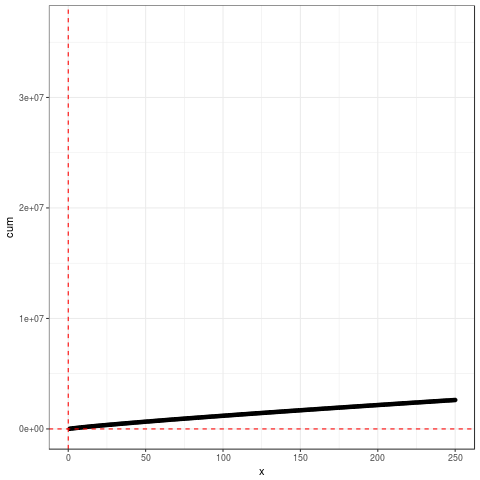

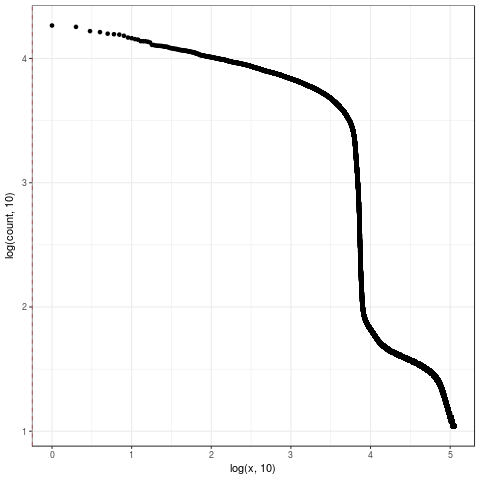

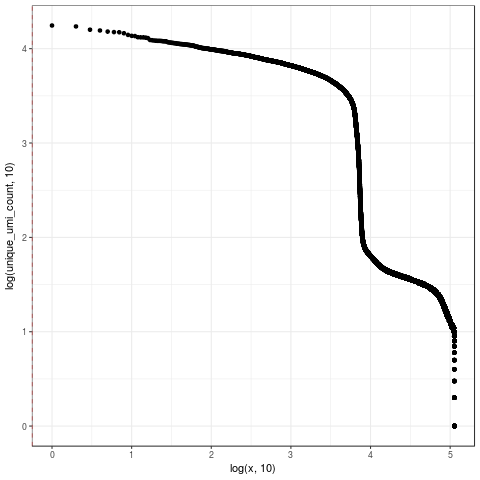

In [35]:
%%R
tmp_df <- duplication_df[order(-duplication_df$count),]
tmp_df$x <- seq(1, length(tmp_df[,1]))
tmp_df$cum <- cumsum(tmp_df$count)

tmp_df2 <- duplication_df[order(-duplication_df$unique_umi_count),]
tmp_df2$x <- seq(1, length(tmp_df2[,1]))
tmp_df2$cum <- cumsum(tmp_df2$unique_umi_count)

print(head(tmp_df))

print(tmp_df[tmp_df$x==length(tmp_df$count>manual_threshold),])

threshold_y_cum = sum(tmp_df[tmp_df$knee==TRUE, "count"])
print(threshold_y_cum)
threshold_x_cum = sum(tmp_df$knee==TRUE)

p <- ggplot(tmp_df, aes(x, cum)) + geom_point() + theme_bw() + xlim(0, 250) +
geom_hline(yintercept=threshold_y_cum, linetype=2, colour="red") +
geom_vline(xintercept=threshold_x_cum, linetype=2, colour="red")
print(p)


p <- ggplot(tmp_df, aes(log(x,10), log(count,10))) + geom_point() + theme_bw() + theme_bw()  +
geom_vline(xintercept=log(threshold_x_cum,10), linetype=2, colour="red")
print(p)

p <- ggplot(tmp_df2, aes(log(x,10), log(unique_umi_count,10))) + geom_point() + theme_bw()  +
geom_vline(xintercept=log(threshold_x_cum,10), linetype=2, colour="red")
print(p)
